#  <span style="color:#cc416d">Dispocisión geográfica de los datos GWS  </span>
###  <span style="color:#cc416d">2003-02-01 al 2022-12-31 </span>

In [55]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.ops import transform
import contextily as ctx
from shapely.geometry import LineString, box
from shapely.geometry import Polygon
from pyproj import Transformer
import contextily as ctx
import matplotlib.patheffects as pe
import xarray as xr
import netCDF4 as nc

###  <span style="color:#cc416d">Ruta </span>

In [5]:
path = "C:/Proyectos/2024/Conejos/mapas/GRACE"
os.chdir(path)
print ("Ruta de trabajo:   " + path)
print ("\U0001F40D")

Ruta de trabajo:   C:/Proyectos/2024/Conejos/mapas/GRACE
🐍


In [42]:
grace = pd.read_csv("GRACE_todos2022.csv")
grace['time'] = pd.to_datetime(grace['time'])
print ("\U0001F40D")

SHAPE_PATH = r"C:/Proyectos/2024/Conejos/mapas/aol_conejos.shp"  # ajusta la ruta

🐍


In [8]:
def edges_from_centers(c):
    c = np.asarray(c, float)
    mids = (c[:-1] + c[1:]) / 2
    first_edge = c[0] - (mids[0] - c[0])
    last_edge  = c[-1] + (c[-1] - mids[-1])
    return np.concatenate(([first_edge], mids, [last_edge]))

print ("\U0001F40D")

🐍


###  <span style="color:#cc416d">Grilla MAESTRA de centros: lon ↑, lat ↑  (tal como en GRACE/xarray)</span> 

In [12]:
lon_centers = np.sort(np.round(grace['lon'].unique(), 6))
lat_centers = np.sort(np.round(grace['lat'].unique(), 6))
nx, ny = len(lon_centers), len(lat_centers)
assert nx * ny == 36, f"Esperaba 36 celdas; nx={nx}, ny={ny}"
print ("\U0001F40D")

🐍


In [11]:
lon_edges = edges_from_centers(lon_centers)   # asc
lat_edges = edges_from_centers(lat_centers)   # asc

lon_to_i = {lon:i for i, lon in enumerate(lon_centers)}
lat_to_j = {lat:j for j, lat in enumerate(lat_centers)}
print ("\U0001F40D")

🐍


###  <span style="color:#cc416d">Seleccionar el PRIMER día y construir matriz 6×6 (orden GRACE)</span>  

In [13]:
t0 = grace['time'].min()
g0 = grace[grace['time'] == t0].copy()
assert len(g0) == 36, f"Para {t0.date()} no hay 36 puntos (hay {len(g0)})"

In [14]:
g0['lon_r'] = np.round(g0['lon'], 6)
g0['lat_r'] = np.round(g0['lat'], 6)

In [15]:
grid = np.full((ny, nx), np.nan, float)  # filas=j (lat ↑), cols=i (lon ↑)
for _, r in g0.iterrows():
    i = lon_to_i[r['lon_r']]
    j = lat_to_j[r['lat_r']]
    grid[j, i] = r['GWS_tavg']

####  <span style="color:#cc416d">Cargar límite y pasarlo a lon/lat (EPSG:4326)</span>

In [35]:
cells = []
vals  = grid.ravel(order='C')  # fila por fila (sur→norte), col por col (oeste→este)
k = 0
for j in range(ny):
    for i in range(nx):
        x0, x1 = lon_edges[i],   lon_edges[i+1]
        y0, y1 = lat_edges[j],   lat_edges[j+1]
        poly = Polygon([(x0,y0), (x1,y0), (x1,y1), (x0,y1)])
        cid  = j*nx + i + 1      # ID 1 abajo-izquierda
        cells.append((cid, vals[k], poly))
        k += 1

gdf_cells = gpd.GeoDataFrame(cells, columns=["cell_id","GWS","geometry"], crs=4326)

###  <span style="color:#cc416d">Para basemap necesitamos 3857</span>   

In [17]:
gdf_cells_3857 = gdf_cells.to_crs(3857)

In [18]:
# Extent del mapa (con pequeño margen)
minx, miny, maxx, maxy = gdf_cells_3857.total_bounds
padx = (maxx - minx)*0.02
pady = (maxy - miny)*0.02
xmin_p, xmax_p = minx - padx, maxx + padx
ymin_p, ymax_p = miny - pady, maxy + pady

####  <span style="color:#cc416d">Límite del acuífero (en grados EPSG:4326)</span>


In [51]:
gdf_limite = gpd.read_file(SHAPE_PATH)            # tu shapefile
if gdf_limite.crs is None:
    gdf_limite = gdf_limite.set_crs(4326)         # ajusta si sabes otro EPSG
gdf_limite_3857 = gdf_limite.to_crs(3857)

###  <span style="color:#cc416d">Basemap (se coloca después de calcular el extent)</span>   

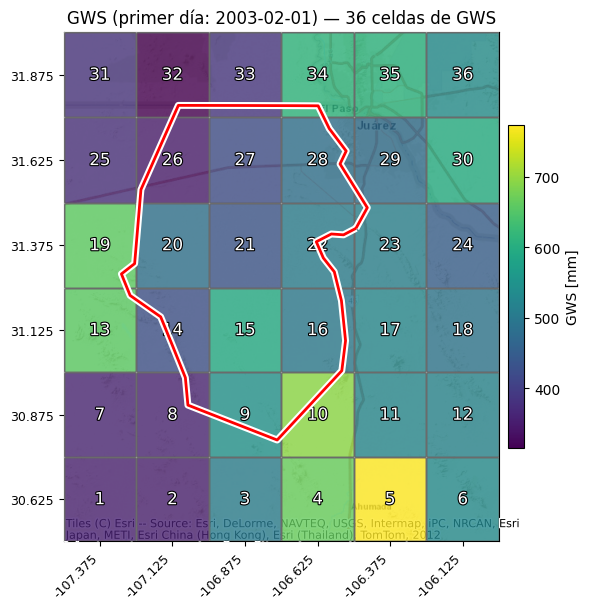

In [53]:
fig, ax = plt.subplots(figsize=(6,8))
ax.set_xlim(xmin_p, xmax_p)
ax.set_ylim(ymin_p, ymax_p)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)  # Web Mercator
ax.set_xlim(xmin_p, xmax_p)
ax.set_ylim(ymin_p, ymax_p)

# PASO 4 (parte visual): plot del primer día con 50% de transparencia
gdf_cells_3857.plot(column='GWS', ax=ax, cmap='viridis',
                    edgecolor='0.6', linewidth=0.8, alpha=0.8, zorder=20)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(vmin=float(np.nanmin(vals)),
                                            vmax=float(np.nanmax(vals))),
                          cmap='viridis'),
    ax=ax, fraction=0.035, pad=0.02
)
cbar.set_label('GWS [mm]')

# PASO 5 (cuadrícula de píxeles, en 3857)
to_3857 = Transformer.from_crs(4326, 3857, always_xy=True)
x_edges_m, _ = to_3857.transform(lon_edges, np.full_like(lon_edges, lat_edges[0]))
_, y_edges_m = to_3857.transform(np.full_like(lat_edges, lon_edges[0]), lat_edges)

for xm in x_edges_m:
    ax.plot([xm, xm], [y_edges_m[0], y_edges_m[-1]], color='0.7', linewidth=1, alpha=0.7, zorder=25)
for ym in y_edges_m:
    ax.plot([x_edges_m[0], x_edges_m[-1]], [ym, ym], color='0.7', linewidth=1, alpha=0.7, zorder=25)

# PASO 6: etiquetas con numeración correcta en el centro de cada celda
lon_cent = (lon_edges[:-1] + lon_edges[1:]) / 2
lat_cent = (lat_edges[:-1] + lat_edges[1:]) / 2
cx_m, cy_m = to_3857.transform(np.tile(lon_cent, ny), np.repeat(lat_cent, nx))  # izq→der, abajo→arriba

for cid, (xm, ym) in enumerate(zip(cx_m, cy_m), start=1):
    ax.text(xm, ym, str(cid), ha='center', va='center', fontsize=12, color='white',
            zorder=50, path_effects=[pe.withStroke(linewidth=1.6, foreground='black')])

# Líneas de grilla (gris claro) usando bordes en metros
for xm in x_edges_m:  # verticales
    ax.plot([xm, xm], [y_edges_m[0], y_edges_m[-1]],
            linewidth=1, color='black', alpha=1, zorder=25)

for ym in y_edges_m:  # horizontales
    ax.plot([x_edges_m[0], x_edges_m[-1]], [ym, ym],
            linewidth=1, color='black', alpha=1, zorder=25)

ax.set_title(f"GWS (primer día: {t0.date()}) — 36 celdas de GWS", zorder=20)

# Transformer 4326 -> 3857
to_3857 = Transformer.from_crs(4326, 3857, always_xy=True)

# 1) Proyectar BORDES a 3857 (para extent y líneas de grilla)
x_edges_m, _ = to_3857.transform(lon_edges, np.full_like(lon_edges, lat_centers[0]))
_, y_edges_m = to_3857.transform(np.full_like(lat_edges, lon_centers[0]), lat_edges)

ax.set_xlim(x_edges_m[0], x_edges_m[-1])
ax.set_ylim(y_edges_m[0], y_edges_m[-1])
ax.set_aspect("equal", adjustable="box")

# (opcional) líneas de grilla en bordes
for xm in x_edges_m:  # verticales
    ax.plot([xm, xm], [y_edges_m[0], y_edges_m[-1]], color='0.7', lw=1, alpha=0.6, zorder=25)
for ym in y_edges_m:  # horizontales
    ax.plot([x_edges_m[0], x_edges_m[-1]], [ym, ym], color='0.7', lw=1, alpha=0.6, zorder=25)

# 2) Proyectar CENTROS a 3857 (para ticks al centro de cada celda)
xticks_m, _ = to_3857.transform(lon_centers, np.full_like(lon_centers, lat_centers[0]))
_, yticks_m = to_3857.transform(np.full_like(lat_centers, lon_centers[0]), lat_centers)

# Límite del acuífero
gdf_limite_3857.boundary.plot(ax=ax, color='white', linewidth=5, zorder=60)
gdf_limite_3857.boundary.plot(ax=ax, color='red',   linewidth=2, zorder=61)


ax.set_xticks(xticks_m)
ax.set_yticks(yticks_m)
ax.set_xticklabels([f"{lon:.3f}" for lon in lon_centers], rotation=45, ha="right", fontsize=9)
ax.set_yticklabels([f"{lat:.3f}" for lat in lat_centers], fontsize=9)

plt.tight_layout()
plt.savefig("Mapa_Base_GRACE.png", dpi=300)
plt.show()

#  <span style="color:#cc416d">Plot sin mapa base</span>

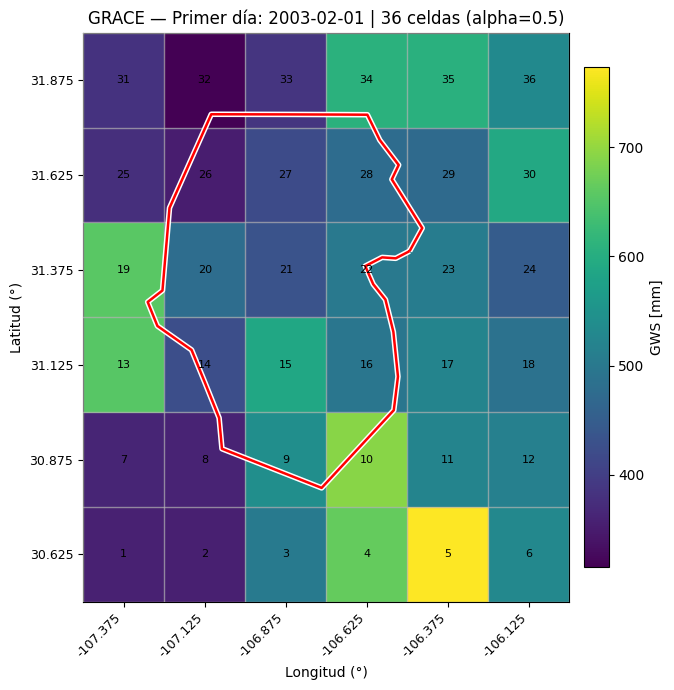

In [69]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# =========================
# ENTRADAS
# =========================
CSV_PATH = "GRACE_todos2022.csv"
SHAPE_PATH = r"C:/Proyectos/2024/Conejos/mapas/aol_conejos.shp"  # ajusta la ruta

# =========================
# 1) Cargar datos (GRACE en grados)
# =========================
grace = pd.read_csv(CSV_PATH)
grace['time'] = pd.to_datetime(grace['time'])

# Centros de la grilla MAESTRA (lon asc, lat asc)
lon_centers = np.sort(np.round(grace['lon'].unique(), 6))
lat_centers = np.sort(np.round(grace['lat'].unique(), 6))
nx, ny = len(lon_centers), len(lat_centers)
assert nx * ny == 36, f"Se esperaban 36 celdas; nx={nx}, ny={ny}"

# Diccionarios índice
lon_to_i = {lon:i for i, lon in enumerate(lon_centers)}
lat_to_j = {lat:j for j, lat in enumerate(lat_centers)}

# Bordes (edges) a partir de centros
def edges_from_centers(c):
    c = np.asarray(c, float)
    mids = (c[:-1] + c[1:]) / 2
    first_edge = c[0] - (mids[0] - c[0])
    last_edge  = c[-1] + (c[-1] - mids[-1])
    return np.concatenate(([first_edge], mids, [last_edge]))

lon_edges = edges_from_centers(lon_centers)   # asc
lat_edges = edges_from_centers(lat_centers)   # asc

# =========================
# 2) Límite del acuífero (en grados EPSG:4326)
# =========================
gdf_limite = gpd.read_file(SHAPE_PATH)
if gdf_limite.crs is None:
    # Ajusta si sabes que tu shapefile tiene otro CRS
    gdf_limite = gdf_limite.set_crs(4326)
else:
    gdf_limite = gdf_limite.to_crs(4326)

# =========================
# 3) Seleccionar el PRIMER día y construir la matriz 6x6 de GWS (opcional para colorear)
# =========================
t0 = grace['time'].min()
g0 = grace[grace['time'] == t0].copy()
assert len(g0) == 36, f"Para {t0.date()} hay {len(g0)} puntos, no 36."

g0['lon_r'] = np.round(g0['lon'], 6)
g0['lat_r'] = np.round(g0['lat'], 6)

grid = np.full((ny, nx), np.nan, float)  # filas=j (lat ↑), cols=i (lon ↑)
for _, r in g0.iterrows():
    i = lon_to_i[r['lon_r']]
    j = lat_to_j[r['lat_r']]
    grid[j, i] = r['GWS_tavg']

# =========================
# 4) Plot en grados (sin basemap): límite + (opcional) campo GWS t0 + grilla + IDs
# =========================
fig, ax = plt.subplots(figsize=(8, 7))

# Extent exacto por bordes (grados)
ax.set_xlim(lon_edges[0], lon_edges[-1])
ax.set_ylim(lat_edges[0], lat_edges[-1])
ax.set_aspect('equal', adjustable='box')

# (Opcional) Pintar GWS del primer día con alpha=0.5
im = ax.imshow(
    grid, origin='lower', cmap='viridis', alpha=1,    # origin='lower' porque lat es ascendente
    extent=[lon_edges[0], lon_edges[-1], lat_edges[0], lat_edges[-1]]
)
cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label('GWS [mm]')

# Límite del acuífero
gdf_limite.boundary.plot(ax=ax, color='white', linewidth=4, zorder=30)
gdf_limite.boundary.plot(ax=ax, color='red',   linewidth=1.8, zorder=31)

# Rejilla gris en los BORDES
for x in lon_edges:  # verticales
    ax.plot([x, x], [lat_edges[0], lat_edges[-1]], color='0.7', lw=1, alpha=0.7, zorder=25)
for y in lat_edges:  # horizontales
    ax.plot([lon_edges[0], lon_edges[-1]], [y, y], color='0.7', lw=1, alpha=0.7, zorder=25)

# Centros y numeración correcta (1 abajo-izquierda → 36 arriba-derecha)
lon_cent = (lon_edges[:-1] + lon_edges[1:]) / 2
lat_cent = (lat_edges[:-1] + lat_edges[1:]) / 2
cid = 1
for j, y in enumerate(lat_cent):      # filas asc (sur→norte)
    for i, x in enumerate(lon_cent):  # cols asc (oeste→este)
        ax.text(x, y, str(cid), ha='center', va='center',
                fontsize=8, color='black', zorder=50)
        cid += 1

# Ticks en los CENTROS de celda con etiquetas lon/lat
ax.set_xticks(lon_cent); ax.set_yticks(lat_cent)
ax.set_xticklabels([f"{lon:.3f}" for lon in lon_centers], rotation=45, ha='right', fontsize=9)
ax.set_yticklabels([f"{lat:.3f}" for lat in lat_centers], fontsize=9)

ax.set_xlabel('Longitud (°)')
ax.set_ylabel('Latitud (°)')
ax.set_title(f'GRACE — Primer día: {t0.date()} | 36 celdas (alpha=0.5)')
plt.tight_layout()
plt.savefig('GRACE_primer_dia_sin_basemap.png', dpi=300)
plt.show()


#  <span style="color:#cc416d">Plot de imagen real de GRACE  </span>

In [56]:
file_GRACE = "C:/1_tesis/6_NC/GWS_20050321.nc"
ncGRACE = xr.open_dataset(file_GRACE, engine='netcdf4')
ncGRACE

<xarray.Dataset> Size: 4MB
Dimensions:                           (lon: 1440, lonv: 2, lat: 720, latv: 2,
                                       time: 1, bnds: 2)
Coordinates:
  * time                              (time) datetime64[ns] 8B 2005-03-21
  * lon                               (lon) float32 6kB -179.9 -179.6 ... 179.9
  * lat                               (lat) float64 6kB -89.88 -89.62 ... 89.88
Dimensions without coordinates: lonv, latv, bnds
Data variables:
    lon_bnds                          (lon, lonv) float64 23kB ...
    lat_bnds                          (lat, latv) float64 12kB ...
    GLDAS_CLSM025_DA1_D_2_2_GWS_tavg  (time, lat, lon) float32 4MB ...
    dataday                           (time) int32 4B ...
    time_bnds                         (time, bnds) datetime64[ns] 16B ...
Attributes:
    Conventions:               CF-1.4
    start_time:                2005-03-21T00:00:00Z
    end_time:                  2005-03-22T00:00:00Z
    temporal_resolution:       daily
    NCO:                       "4.5.3"
    nco_openmp_thread_number:  1

In [66]:
minx =-107.5
miny = 30.5

maxy = 32
maxx = -106

In [67]:
daGRACE = ncGRACE.sel(lon=slice(minx, maxx), lat=slice(miny, maxy))
daGRACE

<xarray.Dataset> Size: 436B
Dimensions:                           (lon: 6, lonv: 2, lat: 6, latv: 2,
                                       time: 1, bnds: 2)
Coordinates:
  * time                              (time) datetime64[ns] 8B 2005-03-21
  * lon                               (lon) float32 24B -107.4 -107.1 ... -106.1
  * lat                               (lat) float64 48B 30.62 30.88 ... 31.88
Dimensions without coordinates: lonv, latv, bnds
Data variables:
    lon_bnds                          (lon, lonv) float64 96B ...
    lat_bnds                          (lat, latv) float64 96B ...
    GLDAS_CLSM025_DA1_D_2_2_GWS_tavg  (time, lat, lon) float32 144B ...
    dataday                           (time) int32 4B ...
    time_bnds                         (time, bnds) datetime64[ns] 16B ...
Attributes:
    Conventions:               CF-1.4
    start_time:                2005-03-21T00:00:00Z
    end_time:                  2005-03-22T00:00:00Z
    temporal_resolution:       daily
    NCO:                       "4.5.3"
    nco_openmp_thread_number:  1

In [64]:
slice(minx, maxx)

slice(-107.5, -106, None)

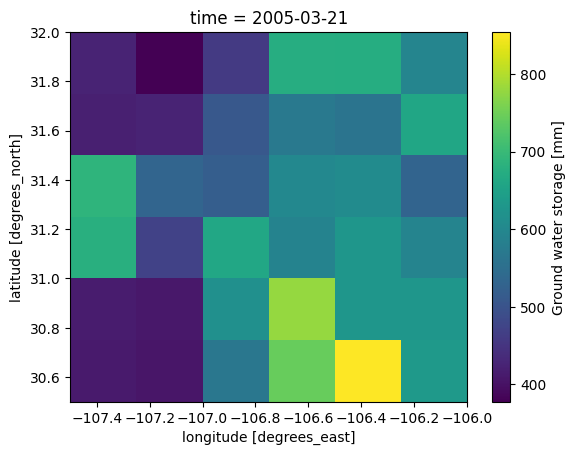

In [68]:
daGRACE["GLDAS_CLSM025_DA1_D_2_2_GWS_tavg"].plot() 